# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [46]:
%matplotlib inline

import torch
import torchvision
import numpy as np

np.seterr(all='raise')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [47]:
# Carregar os datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [49]:
print(len(dataset_train), len(dataset_test))

50000 10000


In [0]:
# Converter para tons de cinza

# Treino
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# Teste
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

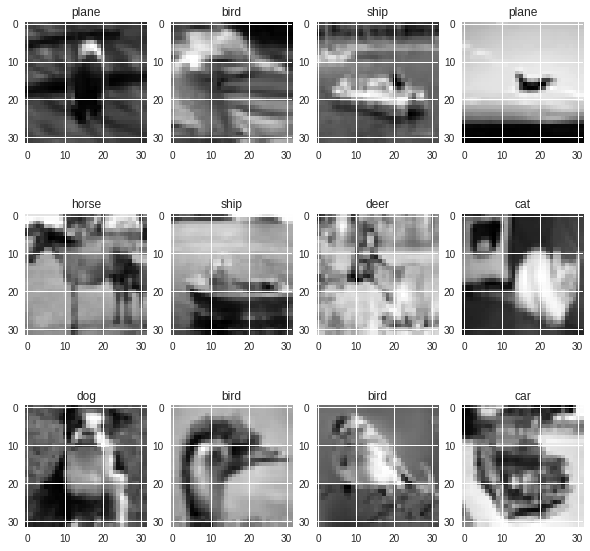

In [51]:
# Mostrar imagens

import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    image_index = random.randint(0, len(dataset_train))
    label = grayscale_dataset_train[image_index][1]
    npimg = grayscale_dataset_train[image_index][0]

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(npimg, cmap='gray')
    plt.title(label)
    
plt.show()

In [0]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [53]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron

In [0]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def perceptron(inputs, weights):
    # Defina o perceptron aqui
    # print(inputs, weights[:len(weights)-1], weights[len(weights)-1])
    # o = np.dot(inputs, weights[:len(weights)-1]) + weights[len(weights)-1]
    #inputs = np.append(inputs, 1)
    o = np.dot(inputs, weights)
    return o


# Treinando o perceptron

In [0]:
def evaluate(weights,dataset):
    hits = 0
    for img,label in dataset:
        img = np.append(img, 1)
        # Defina a métrica de avaliação do perceptron aqui (e.g. acurácia)
        o = perceptron(img, weights)
        y = sigmoid(o)
        if(y >= 0.5 and label == 1):
            hits += 1
        
        elif(y < 0.5 and label == 0):
            hits += 1
            
    accuracy = hits / len(dataset)
    return accuracy
        

In [62]:
# Inicialização
weights = (np.random.rand(1,size) - 0.5)[0]
bias = (np.random.rand(1) - 0.5) 
weights = np.append(weights, bias) 

neta = 0.001  # default = 0.001
np.random.shuffle(linear_dataset_train)
epochs = 200

# Implemente o treino aqui (para separar as duas classes definidas)
accuracies = []
losses = []
hits = 0
loss = 0

for epoch in range(epochs):
    for image, label in linear_dataset_train:
        image = np.append(image, 1)
        
        o = perceptron(image, weights)
        y = sigmoid(o)
        
        if(y >= 0.5 and label == 1):
            hits += 1
        
        elif(y < 0.5 and label == 0):
            hits += 1

        delta_weights = neta * (label - y) * image # * (1 - image)
        weights -= delta_weights
        loss += abs(label - y)
        
    accuracy = hits / len(linear_dataset_train)
    accuracies = np.append(accuracies, accuracy)
    losses = np.append(losses, loss)
    hits = 0
    
    
    print(epoch, accuracy, loss)
    loss = 0
    

FloatingPointError: ignored

In [57]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?
train = evaluate(weights, linear_dataset_train)
test = evaluate(weights, linear_dataset_test)

print(train, test)


0.73458 0.7213


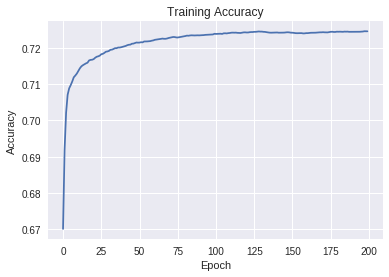

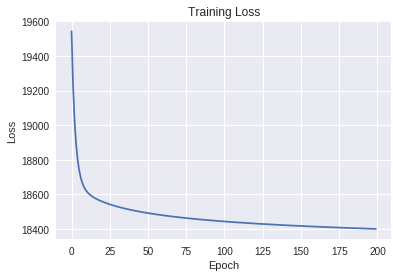

In [59]:
# Caso queiram plotar alguma coisa

import matplotlib.pyplot as plt


plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html

# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?